In [9]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt


In [11]:
mat_path = r"E:\1 Paper MCT\Cutting Tool Paper\Dataset\cutting tool data\mat files data\AE_ALL.mat"

# Class mapping: {'BF', 'GF', 'TF', 'N'}
class_map = {
    'BF': 'BF',
    'GF': 'GF',
    'TF': 'TF',      # You mentioned TF will use data from 'BFI', but loading from TF is fine since it's available.
    'N': 'BFI'
}

data_dict = {}

with h5py.File(mat_path, 'r') as file:
    for class_label, class_key in class_map.items():
        print(f"\nLoading Class: {class_label} (Key: {class_key})")
        class_data = file['AE_ALL'][class_key]
        channels = []
        for ch in range(4):  # 4 channels
            ref = class_data[0][ch]
            ch_data = np.array(file[ref])  # Shape: (1000000, 40)
            channels.append(ch_data)
            print(f"  Channel {ch+1}: {ch_data.shape}")
        data_dict[class_label] = channels



Loading Class: BF (Key: BF)
  Channel 1: (1000000, 40)
  Channel 2: (1000000, 40)
  Channel 3: (1000000, 40)
  Channel 4: (1000000, 40)

Loading Class: GF (Key: GF)
  Channel 1: (1000000, 40)
  Channel 2: (1000000, 40)
  Channel 3: (1000000, 40)
  Channel 4: (1000000, 40)

Loading Class: TF (Key: TF)
  Channel 1: (1000000, 40)
  Channel 2: (1000000, 40)
  Channel 3: (1000000, 40)
  Channel 4: (1000000, 40)

Loading Class: N (Key: BFI)
  Channel 1: (1000000, 40)
  Channel 2: (1000000, 40)
  Channel 3: (1000000, 40)
  Channel 4: (1000000, 40)


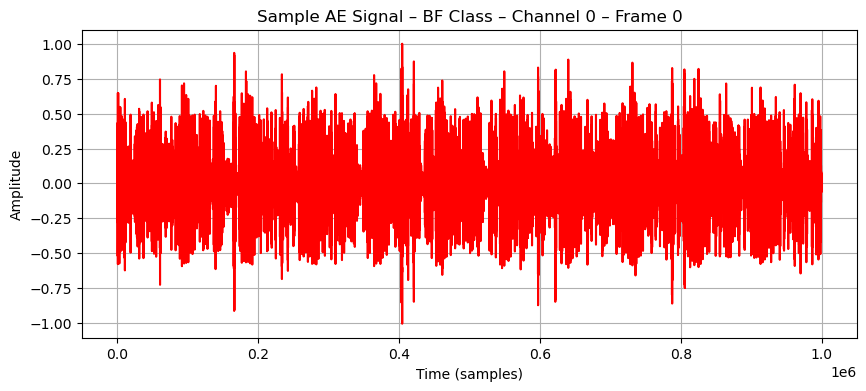

In [12]:
# Sample plot: BF → Channel 0 → Frame 0
bf_ch0 = data_dict['BF'][0]  # Channel 0 of BF
sample_frame = bf_ch0[:, 0]  # First frame
plt.figure(figsize=(10, 4))
plt.plot(sample_frame, color='r')
plt.title("Sample AE Signal – BF Class – Channel 0 – Frame 0")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


In [13]:
import pywt

def wavelet_denoise(signal, wavelet='db4', level=3):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
    denoised_coeffs = [pywt.threshold(c, value=uthresh, mode='soft') for c in coeffs]
    return pywt.waverec(denoised_coeffs, wavelet)


In [14]:
def compute_frame_energy(frame):
    return np.sum(np.square(frame)) / len(frame)

def burst_informed_frame_selection(channel_data, top_k=10):
    selected_frames = []
    for frame_idx in range(channel_data.shape[1]):
        frame = channel_data[:, frame_idx]
        denoised = wavelet_denoise(frame)
        energy = compute_frame_energy(denoised)
        selected_frames.append((denoised, energy))
    
    # Sort by energy descending
    selected_frames.sort(key=lambda x: x[1], reverse=True)
    return [f[0] for f in selected_frames[:top_k]]  # Return only signal part


In [15]:
top_k = 10
burst_selected_data = {}

for cls in ['BF', 'GF', 'TF', 'N']:
    print(f"\nProcessing Class: {cls}")
    class_frames = []
    for ch in range(4):
        print(f"  Channel {ch+1}")
        channel_data = data_dict[cls][ch]  # shape: (1000000, 40)
        selected = burst_informed_frame_selection(channel_data, top_k=top_k)
        class_frames.extend(selected)
    burst_selected_data[cls] = class_frames
    print(f"  => Selected {len(class_frames)} high-energy frames")



Processing Class: BF
  Channel 1
  Channel 2
  Channel 3
  Channel 4
  => Selected 40 high-energy frames

Processing Class: GF
  Channel 1
  Channel 2
  Channel 3
  Channel 4
  => Selected 40 high-energy frames

Processing Class: TF
  Channel 1
  Channel 2
  Channel 3
  Channel 4
  => Selected 40 high-energy frames

Processing Class: N
  Channel 1
  Channel 2
  Channel 3
  Channel 4
  => Selected 40 high-energy frames


In [16]:
from scipy.stats import skew, kurtosis
from scipy.signal import welch, hilbert
from scipy.integrate import simps
import pandas as pd

def extract_features(signal):
    features = {}

    ## Time Domain Features
    features['mean'] = np.mean(signal)
    features['std'] = np.std(signal)
    features['rms'] = np.sqrt(np.mean(signal**2))
    features['max'] = np.max(signal)
    features['min'] = np.min(signal)
    features['peak_to_peak'] = np.ptp(signal)
    features['kurtosis'] = kurtosis(signal)
    features['skewness'] = skew(signal)
    
    ## Frequency Domain Features using Welch's method
    freqs, psd = welch(signal, fs=1e6, nperseg=1024)
    features['mean_freq'] = np.sum(freqs * psd) / np.sum(psd)
    features['peak_freq'] = freqs[np.argmax(psd)]
    features['spec_centroid'] = np.sum(freqs * psd) / np.sum(psd)
    features['spec_bandwidth'] = np.sqrt(np.sum(((freqs - features['spec_centroid'])**2) * psd) / np.sum(psd))

    ## Higher-Order (HOS) & Burst Features
    analytic_signal = hilbert(signal)
    envelope = np.abs(analytic_signal)
    energy = np.sum(envelope**2)
    duration = len(signal) / 1e6  # in seconds (since 1MHz)
    features['energy'] = energy
    features['duration'] = duration
    features['crest_factor'] = features['max'] / features['rms']
    
    return features


In [17]:
all_features = []
all_labels = []

for cls in burst_selected_data:
    print(f"Extracting features for class: {cls}")
    for signal in burst_selected_data[cls]:
        feats = extract_features(signal)
        feats['label'] = cls
        all_features.append(feats)
        all_labels.append(cls)


Extracting features for class: BF
Extracting features for class: GF
Extracting features for class: TF
Extracting features for class: N


In [18]:
df_features = pd.DataFrame(all_features)
df_features.to_csv('features_step3.csv', index=False)
print("✅ Features saved to 'features_step3.csv'")


✅ Features saved to 'features_step3.csv'


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler

# Load and scale data
import pandas as pd
df = pd.read_csv('features_step3.csv')
X = df.drop(columns=['label']).values
labels = df['label'].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)


In [20]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=8):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim * 2)  # mean and log_var
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu, log_var = h.chunk(2, dim=1)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decoder(z)
        return x_recon, mu, log_var


In [21]:
vae = VAE(input_dim=X.shape[1])
optimizer = optim.Adam(vae.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

for epoch in range(100):
    vae.train()
    recon, mu, log_var = vae(X_tensor)
    recon_loss = loss_fn(recon, X_tensor)
    kld = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
    loss = recon_loss + kld
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/100 - Loss: {loss.item():.6f}")


Epoch 10/100 - Loss: 0.173941
Epoch 20/100 - Loss: 0.156283
Epoch 30/100 - Loss: 0.145142
Epoch 40/100 - Loss: 0.134293
Epoch 50/100 - Loss: 0.126859
Epoch 60/100 - Loss: 0.123037
Epoch 70/100 - Loss: 0.113947
Epoch 80/100 - Loss: 0.110773
Epoch 90/100 - Loss: 0.103092
Epoch 100/100 - Loss: 0.103849


In [22]:
vae.eval()
with torch.no_grad():
    latent = vae.encoder(X_tensor)
    mu, _ = latent.chunk(2, dim=1)
    compressed_features = mu.numpy()


In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    compressed_features, labels, test_size=0.25, random_state=42, stratify=labels)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (120, 8)
Test shape: (40, 8)


In [24]:
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Encode class labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Base models
svm = SVC(probability=True, kernel='rbf', C=1)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
rf_meta = RandomForestClassifier(n_estimators=100)


In [25]:
# Train base models
svm.fit(X_train, y_train_enc)
xgb.fit(X_train, y_train_enc)

# Get prediction probabilities
svm_train = svm.predict_proba(X_train)
xgb_train = xgb.predict_proba(X_train)

# Stack for meta classifier input
X_meta_train = np.hstack([svm_train, xgb_train])

# Repeat for test data
svm_test = svm.predict_proba(X_test)
xgb_test = xgb.predict_proba(X_test)
X_meta_test = np.hstack([svm_test, xgb_test])


c:\Users\Muhammad Umar\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:35:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [26]:
# Train meta-classifier on base outputs
rf_meta.fit(X_meta_train, y_train_enc)

# Predict
y_pred_enc = rf_meta.predict(X_meta_test)
y_pred = le.inverse_transform(y_pred_enc)


In [27]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

          BF       0.70      0.70      0.70        10
          GF       0.90      0.90      0.90        10
           N       0.64      0.70      0.67        10
          TF       1.00      0.90      0.95        10

    accuracy                           0.80        40
   macro avg       0.81      0.80      0.80        40
weighted avg       0.81      0.80      0.80        40

Confusion Matrix:

[[7 0 3 0]
 [0 9 1 0]
 [3 0 7 0]
 [0 1 0 9]]


In [28]:
from scipy.signal import hilbert, find_peaks, stft
from scipy.stats import entropy
from scipy.integrate import simps

def extract_features_v2(signal, fs=1_000_000):
    features = {}

    # --- Time Domain ---
    features['mean'] = np.mean(signal)
    features['std'] = np.std(signal)
    features['rms'] = np.sqrt(np.mean(signal**2))
    features['max'] = np.max(signal)
    features['min'] = np.min(signal)
    features['kurtosis'] = kurtosis(signal)
    features['skewness'] = skew(signal)
    features['peak_to_peak'] = np.ptp(signal)
    features['crest_factor'] = features['max'] / (features['rms'] + 1e-6)

    # --- Envelope Analysis ---
    envelope = np.abs(hilbert(signal))
    features['env_mean'] = np.mean(envelope)
    features['env_std'] = np.std(envelope)
    features['env_rms'] = np.sqrt(np.mean(envelope**2))
    features['env_kurt'] = kurtosis(envelope)
    features['env_skew'] = skew(envelope)
    features['env_entropy'] = entropy(np.histogram(envelope, bins=50, density=True)[0] + 1e-12)

    # --- Envelope Shape: Rise Time, Fall Time ---
    peak_idx = np.argmax(envelope)
    rise = envelope[:peak_idx]
    fall = envelope[peak_idx:]
    features['rise_time'] = len(rise) / fs
    features['fall_time'] = len(fall) / fs
    features['envelope_area'] = simps(envelope)

    # --- Burst Peak Metrics ---
    peaks, _ = find_peaks(signal, height=0)
    features['peak_count'] = len(peaks)
    features['peak_density'] = len(peaks) / len(signal)

    # --- ZCR (Zero-Crossing Rate) ---
    zc = np.where(np.diff(np.sign(signal)))[0]
    features['zcr'] = len(zc) / len(signal)

    # --- Frequency Domain (STFT) ---
    f, t, Zxx = stft(signal, fs=fs, nperseg=1024)
    stft_magnitude = np.abs(Zxx)
    stft_energy = np.sum(stft_magnitude**2, axis=0)
    features['stft_entropy'] = entropy(stft_energy / np.sum(stft_energy + 1e-12))

    # --- Band Energy Ratio: 0–500kHz vs. 500kHz–1MHz ---
    band1 = np.logical_and(f >= 0, f <= 500_000)
    band2 = np.logical_and(f > 500_000, f <= fs // 2)
    energy_band1 = np.sum(np.abs(Zxx[band1, :])**2)
    energy_band2 = np.sum(np.abs(Zxx[band2, :])**2)
    features['band_ratio'] = (energy_band2 + 1e-6) / (energy_band1 + 1e-6)

    return features


In [29]:
enhanced_features = []

for cls in burst_selected_data:
    print(f"Extracting enhanced features for class: {cls}")
    for signal in burst_selected_data[cls]:
        feats = extract_features_v2(signal)
        feats['label'] = cls
        enhanced_features.append(feats)

# Save to CSV
import pandas as pd
df_enhanced = pd.DataFrame(enhanced_features)
df_enhanced.to_csv("features_step3_v2.csv", index=False)
print("✅ Enhanced feature set saved to 'features_step3_v2.csv'")


Extracting enhanced features for class: BF


C:\Users\Muhammad Umar\AppData\Local\Temp\ipykernel_28460\1748694205.py:34: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  features['envelope_area'] = simps(envelope)


Extracting enhanced features for class: GF
Extracting enhanced features for class: TF
Extracting enhanced features for class: N
✅ Enhanced feature set saved to 'features_step3_v2.csv'


In [30]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import torch

df = pd.read_csv('features_step3_v2.csv')
X = df.drop(columns=['label']).values
y = df['label'].values

# Normalize
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Convert to tensor
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)


In [31]:
vae = VAE(input_dim=X.shape[1], latent_dim=8)
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()

for epoch in range(100):
    vae.train()
    recon, mu, log_var = vae(X_tensor)
    recon_loss = loss_fn(recon, X_tensor)
    kld = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
    loss = recon_loss + kld
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1} - Loss: {loss.item():.6f}")


Epoch 10 - Loss: 0.154356
Epoch 20 - Loss: 0.142359
Epoch 30 - Loss: 0.134891
Epoch 40 - Loss: 0.127413
Epoch 50 - Loss: 0.121450
Epoch 60 - Loss: 0.112825
Epoch 70 - Loss: 0.109427
Epoch 80 - Loss: 0.107018
Epoch 90 - Loss: 0.105443
Epoch 100 - Loss: 0.102494


In [32]:
vae.eval()
with torch.no_grad():
    latent = vae.encoder(X_tensor)
    mu, _ = latent.chunk(2, dim=1)
    X_latent = mu.numpy()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_latent, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded)


In [33]:
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Define base models
svm = SVC(probability=True, kernel='rbf', C=1)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
rf_meta = RandomForestClassifier(n_estimators=100)

# Train base learners
svm.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# Generate meta features
svm_train = svm.predict_proba(X_train)
xgb_train = xgb.predict_proba(X_train)
X_meta_train = np.hstack([svm_train, xgb_train])

svm_test = svm.predict_proba(X_test)
xgb_test = xgb.predict_proba(X_test)
X_meta_test = np.hstack([svm_test, xgb_test])


c:\Users\Muhammad Umar\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:40:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [34]:
# Train meta classifier
rf_meta.fit(X_meta_train, y_train)

# Predict
y_pred = rf_meta.predict(X_meta_test)


In [35]:
from sklearn.metrics import classification_report, confusion_matrix
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)

print("📊 Classification Report:\n")
print(classification_report(y_test_labels, y_pred_labels))

print("🔢 Confusion Matrix:\n")
print(confusion_matrix(y_test_labels, y_pred_labels))


📊 Classification Report:

              precision    recall  f1-score   support

          BF       0.46      0.60      0.52        10
          GF       1.00      0.90      0.95        10
           N       0.50      0.40      0.44        10
          TF       1.00      1.00      1.00        10

    accuracy                           0.72        40
   macro avg       0.74      0.72      0.73        40
weighted avg       0.74      0.72      0.73        40

🔢 Confusion Matrix:

[[ 6  0  4  0]
 [ 1  9  0  0]
 [ 6  0  4  0]
 [ 0  0  0 10]]
